In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [28]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30

# dataframe with time offset info used for 3D reconstruction
T_off = pd.read_pickle("./data/time_offset.pk")
T_off

,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# Read dE/dx data from SRIM

In [29]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




Text(0, 0.5, 'dE/dx [eV/cm] ')

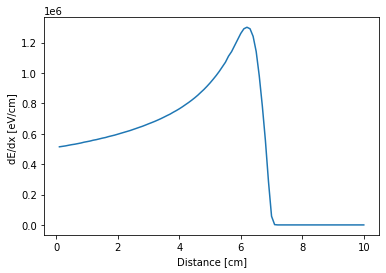

In [30]:
plt.plot(dEdx_data[0],dEdx)
plt.xlabel("Distance [cm]")
plt.ylabel("dE/dx [eV/cm] ")


# Simulate Po210 alpha tracks

In [31]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 100, theta_min = theta_min, theta_max = theta_max, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max+0.1,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




# Simulate readout


In [32]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 604, v_drift = 0.0008, Charge_integration = True, DL = 1.2, pitch_z = 0.02, G_x = 9.0, G_y = 4.5):

    #convert pitch to cm
    pitch_x = pitch_x * 1e-4
    pitch_y = pitch_y * 1e-4
    
    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.track

        x_positions = []
        x_charges = []
        x_times = []
        adcs0 = []
        strips0 = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):


                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) *Gain * CS / (CS+1.0)

                    if charge_detected > thres_x:
                        
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips0 += [np.where(x_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs0 += [min( charge_detected/6241.5*G_x, 1023.0 ) ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist *Gain * CS / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_x]
                    charge_detected = charge_detected [charge_detected>thres_x]


                    x_times += list(bin_centers/v_drift)
                    x_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    x_charges += list(charge_detected)

        

        y_positions = []
        y_charges = []
        y_times = []
        adcs1 = []
        strips1 = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips1 += [np.where(y_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs1 += [ min( charge_detected/6241.5*G_y, 1023.0 ) ] # The min imposes saturation of ADC scale

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist * Gain / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_y]
                    charge_detected = charge_detected [charge_detected>thres_y]


                    y_times += list(bin_centers/v_drift)
                    y_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    y_charges += list(charge_detected)

        hits = hits.append({'strips_x' : np.array(x_positions), 'strips0' : np.array(strips0),  'strips_y' : np.array(y_positions), 'strips1' : np.array(strips1), 'times_x' : np.array(x_times), 'times0' : np.array(x_times), 'times_y' : np.array(y_times), 'times1' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'adcs0' :  np.array(adcs0), 'electrons_y' : np.array(y_charges), 'adcs1' :  np.array(adcs1) }, ignore_index = True)
        
    return hits


# Assess point resolution versus absolute z

In [33]:
def get_PR(tracks, mu = -6.7, sigma = 16.4 , n_sigma = 3, G_x = 9.0, G_y = 4.5, n_strips_x = 500, n_strips_y=500, pitch_x=200, pitch_y=200, theta_min = theta_min, theta_max = theta_max):

    # Analyze point resolution
    all_z = np.array([])
    all_c = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = row, Mult_factor = 1.0, gain_x=G_x, gain_y=G_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y) # Mult factor always 1 for sim
            
            # Remove delayed hits (as discussed in the slides)
            #dsp.prune_track(T_L = 0, T_H=250)
            dsp.mask_channels(masked_x_channels=[296,306,307,326],masked_y_channels=None)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            
            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_c = np.append(all_c,c)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c, start = 0.0, stop = 1.2, step = 0.2,plot=False)



    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

# Simulate Po210 in UH DLC Quadrant a



In [85]:
df_resolution = pd.DataFrame(columns = ['Name','x_res', 'x_res_err', 'y_res', 'y_res_err','abs_z'])

In [86]:
Gain = 604
pitch_x = 200               # in um
pitch_y = 200               # in um
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0     # in mV/fC
electronic_gain_y = 4.5     # in mV/fC

thres =  0
peaking_time = 100

/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


sigma x:  63.16177235976015 +/- 0.982262629647852
sigma y:  55.313375325564365 +/- 0.6389157663933489
sigma x:  47.701327826606544 +/- 0.9622611500013355
sigma y:  -48.155679242781844 +/- 0.7391818282738151
sigma x:  48.17155732252104 +/- 0.9727969171824776
sigma y:  51.7854859856977 +/- 0.8289014516200623
sigma x:  51.54641628840914 +/- 1.0650167006324578
sigma y:  53.38462427777141 +/- 0.9905630978518026
sigma x:  57.15027437886584 +/- 1.1794938583410977
sigma y:  -59.26346078660194 +/- 0.987000130888605
sigma x:  72.08295055269139 +/- 1.0196415736837254
sigma y:  -70.50552122323205 +/- 1.1285115341904175


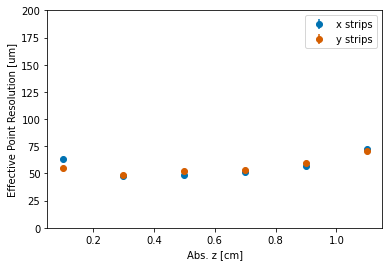

In [87]:
# Charge sharing
Charge_sharing = 0.41

# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3


# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = peaking_time, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = thres/electronic_gain_x*6241.5, thres_y =  thres/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )


df_resolution = df_resolution.append({'Name' : "UH_DLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UH NoDLC Quadrant a

sigma x:  68.54977861382348 +/- 0.9691499404314057
sigma y:  62.701922449588096 +/- 0.6844975705638495
sigma x:  54.008349150794864 +/- 0.9009885037508524
sigma y:  57.22079643776868 +/- 0.8557480452694683
sigma x:  53.68165505008784 +/- 0.849772020860078
sigma y:  -56.84613414463861 +/- 0.8385092724027939
sigma x:  54.63444893836367 +/- 0.9286680382232476
sigma y:  -60.59308954762641 +/- 0.8766021407191419
sigma x:  -62.33480967527934 +/- 1.076569691731442
sigma y:  63.96815952490375 +/- 1.0930245256219913
sigma x:  77.06947647706637 +/- 1.071177620917734
sigma y:  74.94614586424797 +/- 1.0158409720858017


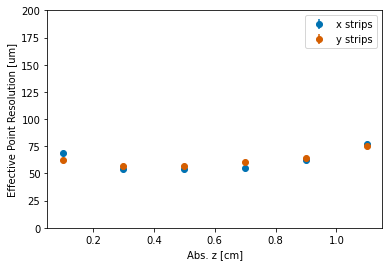

In [88]:
# charge sharing
Charge_sharing = 0.62

# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = peaking_time, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = thres/electronic_gain_x*6241.5, thres_y =  thres/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )


df_resolution = df_resolution.append({'Name' : "UH_NoDLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)


# Make plots

In [89]:
# Load exp data
df_exp = pd.read_pickle("./data/resolution_exp.pk")


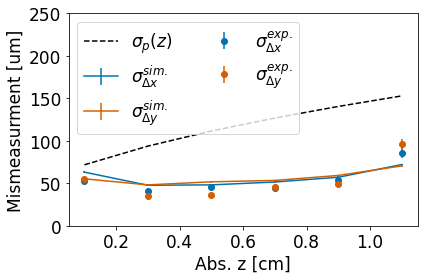

In [90]:
# index specifying detector
index = 0

abs_z = np.array(df_exp.iloc[index].abs_z)
x_res = np.array(df_exp.iloc[index].x_res)
x_res_err = np.array(df_exp.iloc[index].x_res_err)
y_res = np.array(df_exp.iloc[index].y_res)
y_res_err = np.array(df_exp.iloc[index].y_res_err)


x_res_sim = np.array(df_resolution.iloc[index].x_res)
x_res_err_sim = np.array(df_resolution.iloc[index].x_res_err)
y_res_sim = np.array(df_resolution.iloc[index].y_res)
y_res_err_sim = np.array(df_resolution.iloc[index].y_res_err)

DTrans = 0.0135


plt.figure()
plt.errorbar(abs_z,x_res_sim,x_res_err_sim,color=colors["blue"],label="$\sigma_{\Delta x}^{sim.}$")
plt.errorbar(abs_z,y_res_sim,y_res_err_sim,color=colors["red"],label="$\sigma_{\Delta y}^{sim.}$")
plt.errorbar(abs_z,x_res,x_res_err, color=colors["blue"],fmt='o',label="$\sigma_{\Delta x}^{exp.}$")
plt.errorbar(abs_z,y_res,y_res_err, color=colors["red"],fmt='o',label="$\sigma_{\Delta y}^{exp.}$")
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), "--",color=colors["black"],label="$\sigma_p(z)$")
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(ncol=2,fontsize=17)
plt.ylim((0,250))
plt.xlabel("Abs. z [cm]",fontsize=17)
plt.ylabel("Mismeasurment [um]",fontsize=17)
plt.tight_layout()
plt.savefig("./figures/UH_DLC_PR.pdf")


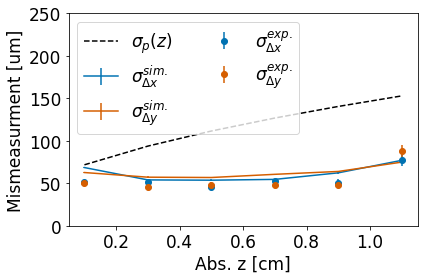

In [91]:
# index specifying detector
index = 1

abs_z = np.array(df_exp.iloc[index].abs_z)
x_res = np.array(df_exp.iloc[index].x_res)
x_res_err = np.array(df_exp.iloc[index].x_res_err)
y_res = np.array(df_exp.iloc[index].y_res)
y_res_err = np.array(df_exp.iloc[index].y_res_err)


x_res_sim = np.array(df_resolution.iloc[index].x_res)
x_res_err_sim = np.array(df_resolution.iloc[index].x_res_err)
y_res_sim = np.array(df_resolution.iloc[index].y_res)
y_res_err_sim = np.array(df_resolution.iloc[index].y_res_err)


plt.figure()
plt.errorbar(abs_z,x_res_sim,x_res_err_sim,color=colors["blue"],label="$\sigma_{\Delta x}^{sim.}$")
plt.errorbar(abs_z,y_res_sim,y_res_err_sim,color=colors["red"],label="$\sigma_{\Delta y}^{sim.}$")
plt.errorbar(abs_z,x_res,x_res_err, color=colors["blue"],fmt='o',label="$\sigma_{\Delta x}^{exp.}$")
plt.errorbar(abs_z,y_res,y_res_err, color=colors["red"],fmt='o',label="$\sigma_{\Delta y}^{exp.}$")
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), "--",color=colors["black"],label="$\sigma_p(z)$")
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(ncol=2,fontsize=17)
plt.ylim((0,250))
plt.xlabel("Abs. z [cm]",fontsize=17)
plt.ylabel("Mismeasurment [um]",fontsize=17)
plt.tight_layout()
plt.savefig("./figures/UH_NoDLC_PR.pdf")
